train: 25,000 images of dogs and cats.label as the filename
test: 12,500
1=dog, 0=cat

# Method
pre-trained model

导入库

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import zipfile
import random
from torchinfo import summary

# 参数
- image size: 224
- folder: train test
- image classes: Dog & Cat
- training data set(20,000) 50% training  50% validation
- pre-trained model: ResNet-50
- epochs: 10

In [1]:
TEST_SIZE = 0.5
RANDOM_STATE = 2008
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = 'DATA'
TRAIN_FOLDER = './DATA/train'
TEST_FOLDER = './DATA/test'
IMG_SIZE = 224
RESNET_WEIGHT_PATH= r'pretrained\hub\checkpoints\resnet50-11ad3fa6.pth'

In [2]:
import os
import torch
from torchvision.models import ResNet50_Weights
from torchvision import models

# 创建pretrained文件夹
pretrained_dir = './pretrained'
if not os.path.exists(pretrained_dir):
    os.makedirs(pretrained_dir)
    print(f"创建文件夹{pretrained_dir}")

In [3]:
# 加载预训练模型 ResNet50
os.environ['TORCH_HOME'] = pretrained_dir  # 设置TORCH_HOME环境变量
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# 保存模型到pretrained文件夹
# model_path = os.path.join(pretrained_dir, 'resnet50_pretrained.pth')
# torch.save(resnet50.state_dict(), model_path)
# print(f"模型已保存到{model_path}")

In [4]:
# 读取数据
# SAMPLE_SIZE 可以减少/扩大训练集
train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

In [7]:
import zipfile
# 解压数据集
with zipfile.ZipFile(train_image_path, 'r') as z:
    z.extractall("DATA")
    print(f"训练数据已解压到./DATA")

训练数据已解压到./DATA


In [8]:
with zipfile.ZipFile(test_image_path, 'r') as z:
    z.extractall("DATA")
    print(f"测试数据已解压到./DATA")

测试数据已解压到./DATA


In [5]:
train_image_list = os.listdir(os.path.join(PATH, 'train'))
# 打乱训练集采样
import random
random.seed(RANDOM_STATE)
random.shuffle(train_image_list)
train_image_list = train_image_list[:SAMPLE_SIZE]  # 采样前SAMPLE_SIZE个数据
test_image_list = os.listdir(os.path.join(PATH, 'test'))

In [6]:
train_image_list[0:5]

['cat.5128.jpg',
 'cat.4965.jpg',
 'cat.6662.jpg',
 'dog.9802.jpg',
 'cat.7444.jpg']

In [7]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[0]
    if pet == 'cat':
        return [1, 0]  # Cat
    elif pet == 'dog':
        return [0, 1]  # Dog
    else:
        raise ValueError("Unknown label in image name")

In [8]:
from tqdm import tqdm
import cv2
import numpy as np
from random import shuffle
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER, img)
        if isTrain:
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data_df.append([np.array(img), np.array(label)])
    shuffle(data_df)
    return data_df

In [ ]:
# 改进的数据集类
class CatDogDataset(Dataset):
    def __init__(self, image_list, data_folder, transform=None, is_train=True):
        self.image_list = image_list
        self.data_folder = data_folder
        self.transform = transform
        self.is_train = is_train
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.data_folder, img_name)
        
        # 读取图像
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_train:
            # 提取标签
            label = 1 if img_name.startswith('dog') else 0
            return image, label
        else:
            # 测试集返回图像名
            return image, img_name.split('.')[0]

# 定义数据增强和预处理
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet标准化
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 数据探索
类别分布

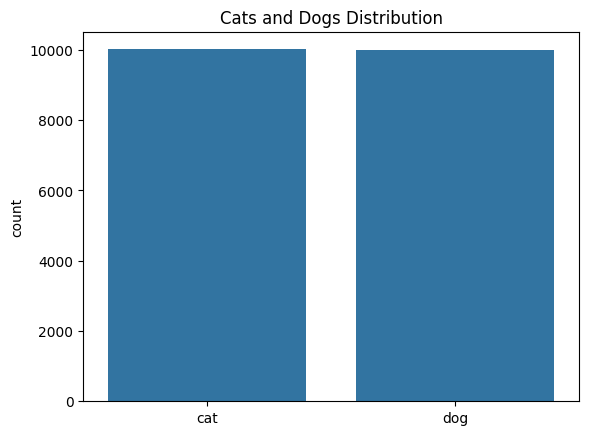

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[0])
    sns.countplot(x=labels)
    plt.title('Cats and Dogs Distribution')

plot_image_list_count(train_image_list)

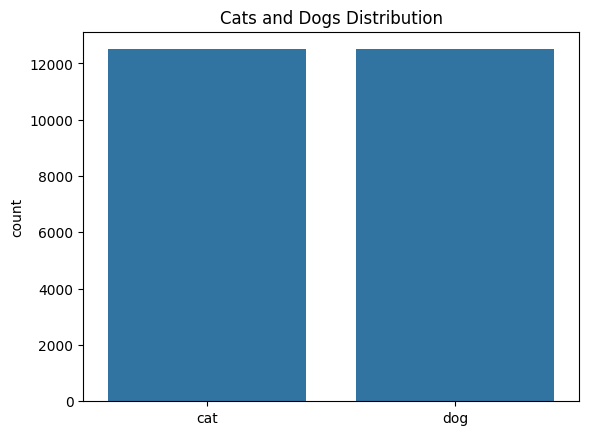

In [10]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))

In [11]:
train = process_data(train_image_list, TRAIN_FOLDER, isTrain=True)

100%|██████████| 20000/20000 [04:18<00:00, 77.42it/s]


In [12]:
def show_image(datas, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(datas[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label == 1:
            str_label = 'Dog'
        else:
            str_label = 'Cat'
        if(isTest):
            str_label = 'None'
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title(str_label)
    plt.show()
    

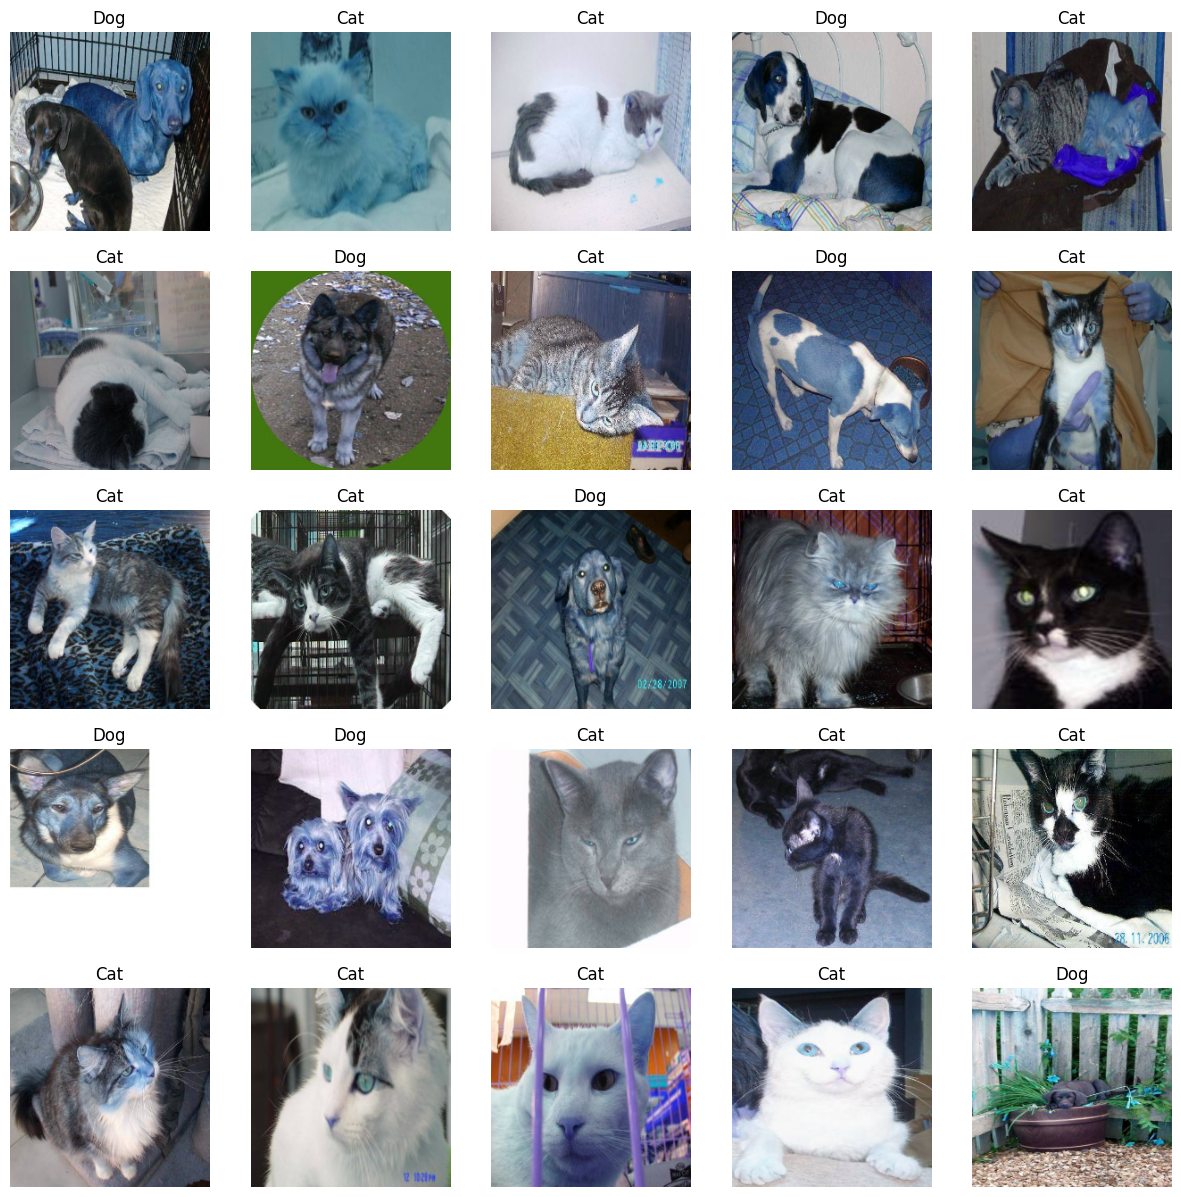

In [13]:
show_image(train, isTest=False)

In [14]:
test = process_data(test_image_list, TEST_FOLDER, isTrain=False)

100%|██████████| 12500/12500 [00:22<00:00, 558.87it/s]


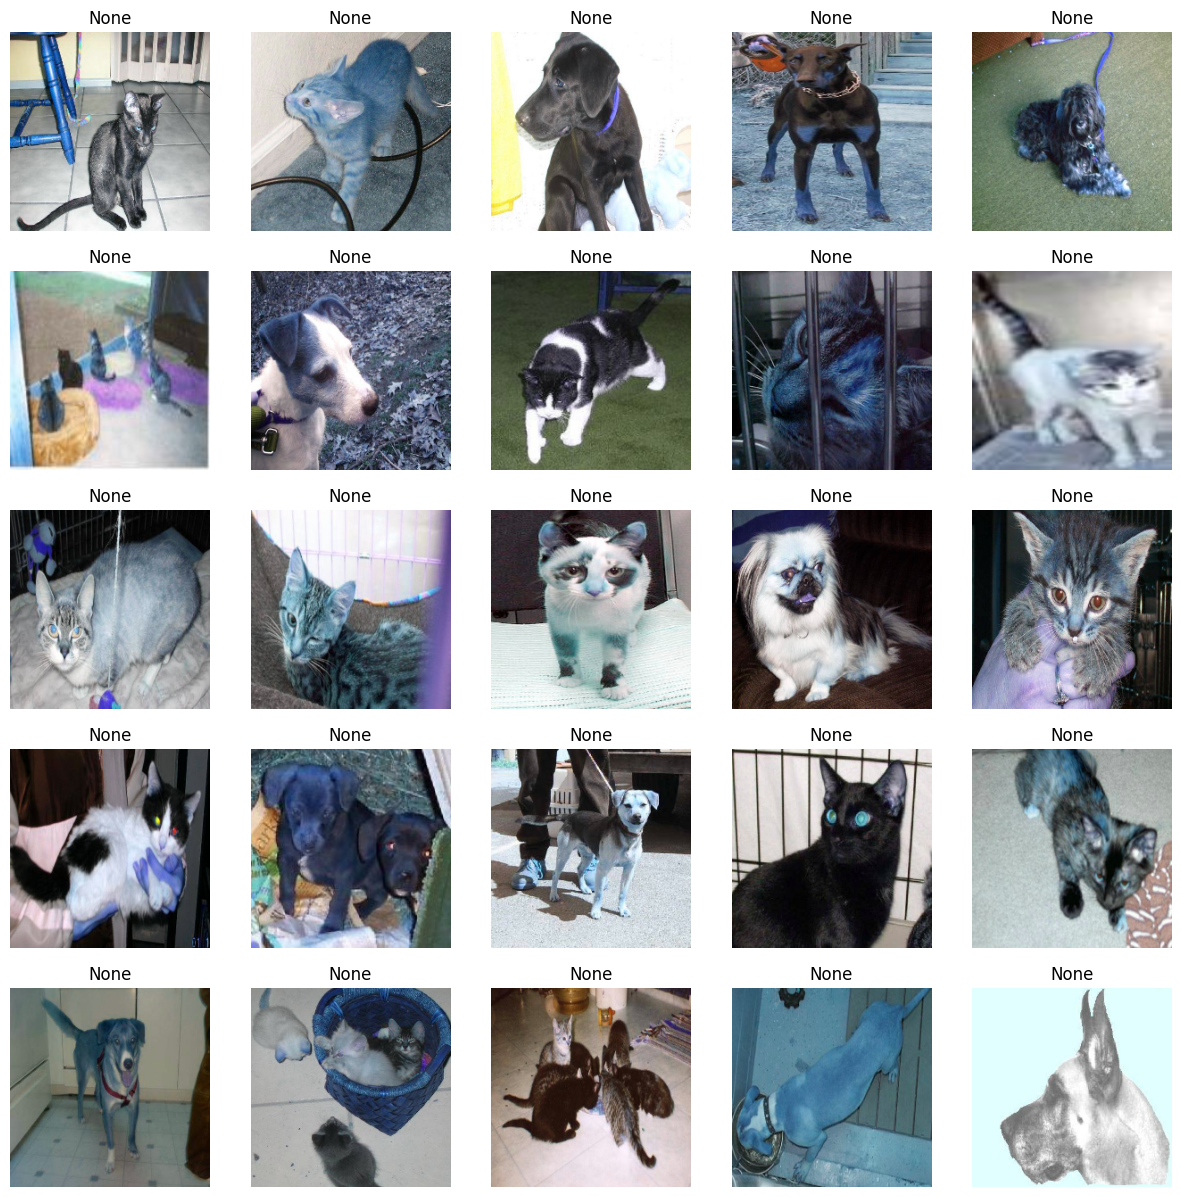

In [15]:
show_image(test, isTest=True)

# Model
## prepare the model

In [16]:
# 准备train data
X = np.array([data[0] for data in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([data[1] for data in train])

In [17]:
X.shape, y.shape

((20000, 224, 224, 3), (20000, 2))

In [18]:
import torch.nn as nn
# 准备模型
resnet50 = models.resnet50(weights=None)
resnet50.load_state_dict(torch.load(RESNET_WEIGHT_PATH))


<All keys matched successfully>

In [19]:
# 移除最后的分类层
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])  # 移除最后的全连接层

# 添加全局最大池化和展平
resnet50.add_module('global_max_pool', nn.AdaptiveMaxPool2d(1))
resnet50.add_module('flatten', nn.Flatten())

In [ ]:
# 改进的模型类
class ImprovedCatDogModel(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5, pretrained=True):
        super(ImprovedCatDogModel, self).__init__()
        
        # 使用预训练的ResNet50
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        
        # 冻结前几层
        for param in list(self.backbone.parameters())[:-20]:  # 只训练最后20层
            param.requires_grad = False
            
        # 获取特征维度
        num_features = self.backbone.fc.in_features
        
        # 替换分类器
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)
    
    def unfreeze_more_layers(self):
        """解冻更多层进行微调"""
        for param in self.backbone.parameters():
            param.requires_grad = True

In [21]:
model = MyModel(num_classes=NUM_CLASSES)

# 设置主干网络可训练
for param in model.backbone.parameters():
    param.requires_grad = True

In [ ]:
# 改进的训练配置
def get_optimizer_and_scheduler(model, lr=0.001):
    # 使用Adam优化器，通常比SGD效果更好
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # 添加学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    return optimizer, scheduler

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 早停机制类
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            
        return self.counter >= self.patience

# 训练函数
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, 
                num_epochs, device, early_stopping=None):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # 更新进度条
            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{correct_predictions/total_samples:.4f}'
            })
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total_samples += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = val_correct_predictions / val_total_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # 学习率调度
        scheduler.step(epoch_val_loss)
        
        # 保存最佳模型
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # 早停检查
        if early_stopping and early_stopping(epoch_val_loss):
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
            
        print('-' * 60)
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [23]:
from torchinfo import summary
# 显示模型摘要，需要指定输入尺寸
summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))


Layer (type:depth-idx)                        Output Shape              Param #
MyModel                                       [64, 2]                   --
├─Sequential: 1-1                             [64, 2048]                --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        128
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [64, 256, 56, 56]         75,008
│    │    └─Bottleneck: 3-2                   [64, 256, 56, 56]         70,400
│    │    └─Bottleneck: 3-3                   [64, 256, 56, 56]         70,400
│    └─Sequential: 2-6                        [64, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [64, 512, 28, 28]         379,392

In [24]:
# 方法4: 计算模型参数总数
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model):,}")

Total trainable parameters: 23,512,130


In [25]:
# 划分训练集和验证集
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
# 使用改进的数据集和数据加载器
# 分割训练集
train_indices, val_indices = train_test_split(
    range(len(train_image_list)), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=[img.split('.')[0] for img in train_image_list]  # 保持类别平衡
)

train_files = [train_image_list[i] for i in train_indices]
val_files = [train_image_list[i] for i in val_indices]

# 创建数据集
train_dataset = CatDogDataset(train_files, TRAIN_FOLDER, train_transform, is_train=True)
val_dataset = CatDogDataset(val_files, TRAIN_FOLDER, val_transform, is_train=True)
test_dataset = CatDogDataset(test_image_list, TEST_FOLDER, val_transform, is_train=False)

# 创建数据加载器（优化性能）
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,  # 多进程加载数据
    pin_memory=True if torch.cuda.is_available() else False,  # 固定内存
    drop_last=True  # 丢弃最后一个不完整的batch
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")

In [26]:
# 训练模型 - PyTorch版本
import torch
from torch.utils.data import DataLoader, TensorDataset

# 数据预处理 - 转换为PyTorch张量并调整维度
# PyTorch需要NCHW格式 (N, C, H, W)，而当前是NHWC格式
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # 归一化到[0,1]
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # 转换为类别索引
y_val_tensor = torch.tensor(y_val, dtype=torch.long)



In [27]:
X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape

(torch.Size([10000, 3, 224, 224]),
 torch.Size([10000, 2]),
 torch.Size([10000, 3, 224, 224]),
 torch.Size([10000, 2]))

In [28]:
# 将one-hot编码转换为类别索引
y_train_labels = torch.argmax(y_train_tensor, dim=1)
y_val_labels = torch.argmax(y_val_tensor, dim=1)

In [29]:
y_train_labels.shape, y_val_labels.shape

(torch.Size([10000]), torch.Size([10000]))

In [ ]:
# 设备配置和混合精度训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# 创建改进的模型
model = ImprovedCatDogModel(num_classes=NUM_CLASSES, dropout_rate=0.3, pretrained=True)
model = model.to(device)

# 启用混合精度训练（如果支持）
use_amp = torch.cuda.is_available() and hasattr(torch.cuda, 'amp')
scaler = torch.cuda.amp.GradScaler() if use_amp else None

print(f"Mixed precision training: {'Enabled' if use_amp else 'Disabled'}")

# 获取优化器和调度器
optimizer, scheduler = get_optimizer_and_scheduler(model, lr=0.001)

# 早停机制
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

Using device: cuda


In [ ]:
# 开始训练
print("开始训练...")
print(f"模型参数总数: {sum(p.numel() for p in model.parameters()):,}")
print(f"可训练参数数: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=NO_EPOCHS,
    device=device,
    early_stopping=early_stopping
)

print("训练完成！")

开始训练...
Epoch 1/20, Batch 0/157, Loss: 0.6682
Epoch 1/20, Batch 0/157, Loss: 0.6682
Epoch 1/20, Batch 50/157, Loss: 0.1596
Epoch 1/20, Batch 50/157, Loss: 0.1596
Epoch 1/20, Batch 100/157, Loss: 0.1489
Epoch 1/20, Batch 100/157, Loss: 0.1489
Epoch 1/20, Batch 150/157, Loss: 0.0792
Epoch 1/20, Batch 150/157, Loss: 0.0792
Epoch 1/20:
  Train Loss: 0.1957, Train Acc: 0.9625
  Val Loss: 0.0794, Val Acc: 0.9842
--------------------------------------------------
Epoch 1/20:
  Train Loss: 0.1957, Train Acc: 0.9625
  Val Loss: 0.0794, Val Acc: 0.9842
--------------------------------------------------
Epoch 2/20, Batch 0/157, Loss: 0.0656
Epoch 2/20, Batch 0/157, Loss: 0.0656
Epoch 2/20, Batch 50/157, Loss: 0.0564
Epoch 2/20, Batch 50/157, Loss: 0.0564
Epoch 2/20, Batch 100/157, Loss: 0.0376
Epoch 2/20, Batch 100/157, Loss: 0.0376
Epoch 2/20, Batch 150/157, Loss: 0.0215
Epoch 2/20, Batch 150/157, Loss: 0.0215
Epoch 2/20:
  Train Loss: 0.0564, Train Acc: 0.9873
  Val Loss: 0.0442, Val Acc: 0.988

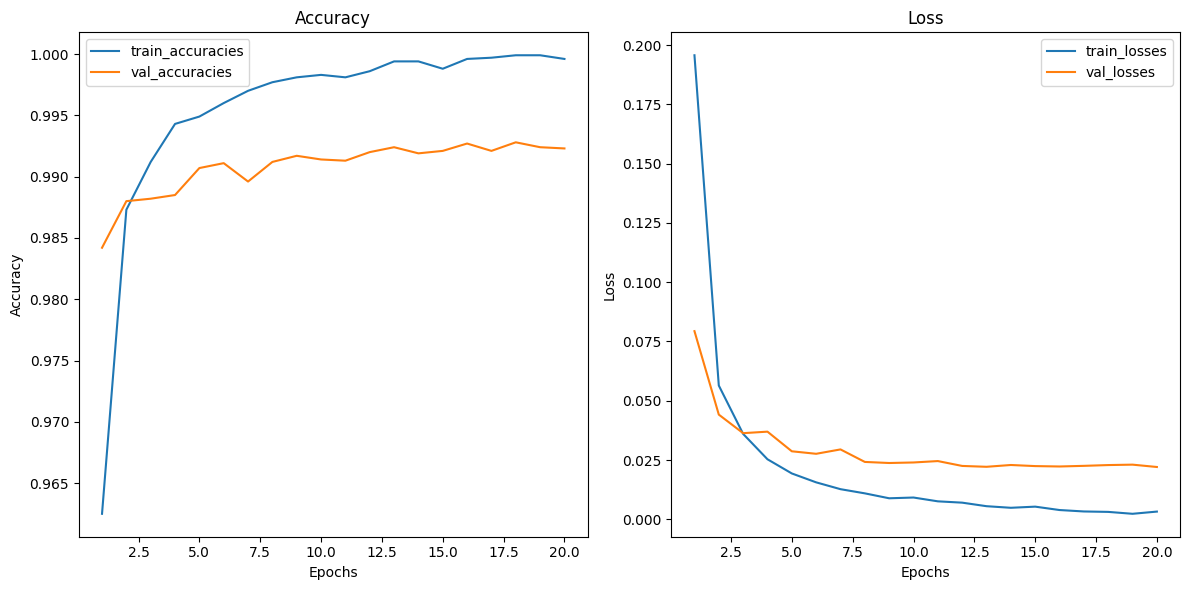

In [33]:
# 验证精度和损失
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(train_accuracies, train_losses, val_accuracies, val_losses):
    epochs = range(1, NO_EPOCHS + 1)

    plt.figure(figsize=(12, 6))
    # 绘制训练和验证精度
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='train_accuracies')
    plt.plot(epochs, val_accuracies, label='val_accuracies')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # 绘制训练和验证损失
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='train_losses')
    plt.plot(epochs, val_losses, label='val_losses')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_accuracy_and_loss(train_accuracies, train_losses, val_accuracies, val_losses)

In [34]:
# 验证集的精度与损失
score = model.eval()
val_running_loss = 0.0
val_correct_predictions = 0

for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    val_running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    val_correct_predictions += (predicted == labels).sum().item()
    val_total_samples = labels.size(0)

val_accuracy = val_correct_predictions / val_total_samples
val_loss = val_running_loss / len(val_loader)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Validation Loss: 0.0221, Validation Accuracy: 620.1875


In [35]:
# 验证集每一类的精度
from sklearn.metrics import classification_report
y_val_pred = []
y_val_true = []
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_val_pred.extend(predicted.cpu().numpy())
    y_val_true.extend(labels.cpu().numpy())
print(classification_report(y_val_true, y_val_pred, target_names=['Cat', 'Dog']))



              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      4998
         Dog       0.99      0.99      0.99      5002

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
# 详细的模型评估
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, val_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="评估中"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 加载最佳模型进行评估
model.load_state_dict(torch.load('best_model.pth'))
y_pred, y_true = evaluate_model(model, val_loader, device)

# 打印分类报告
class_names = ['Cat', 'Dog']
print("分类报告:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 绘制混淆矩阵
plot_confusion_matrix(y_true, y_pred, class_names)

# 准备提交

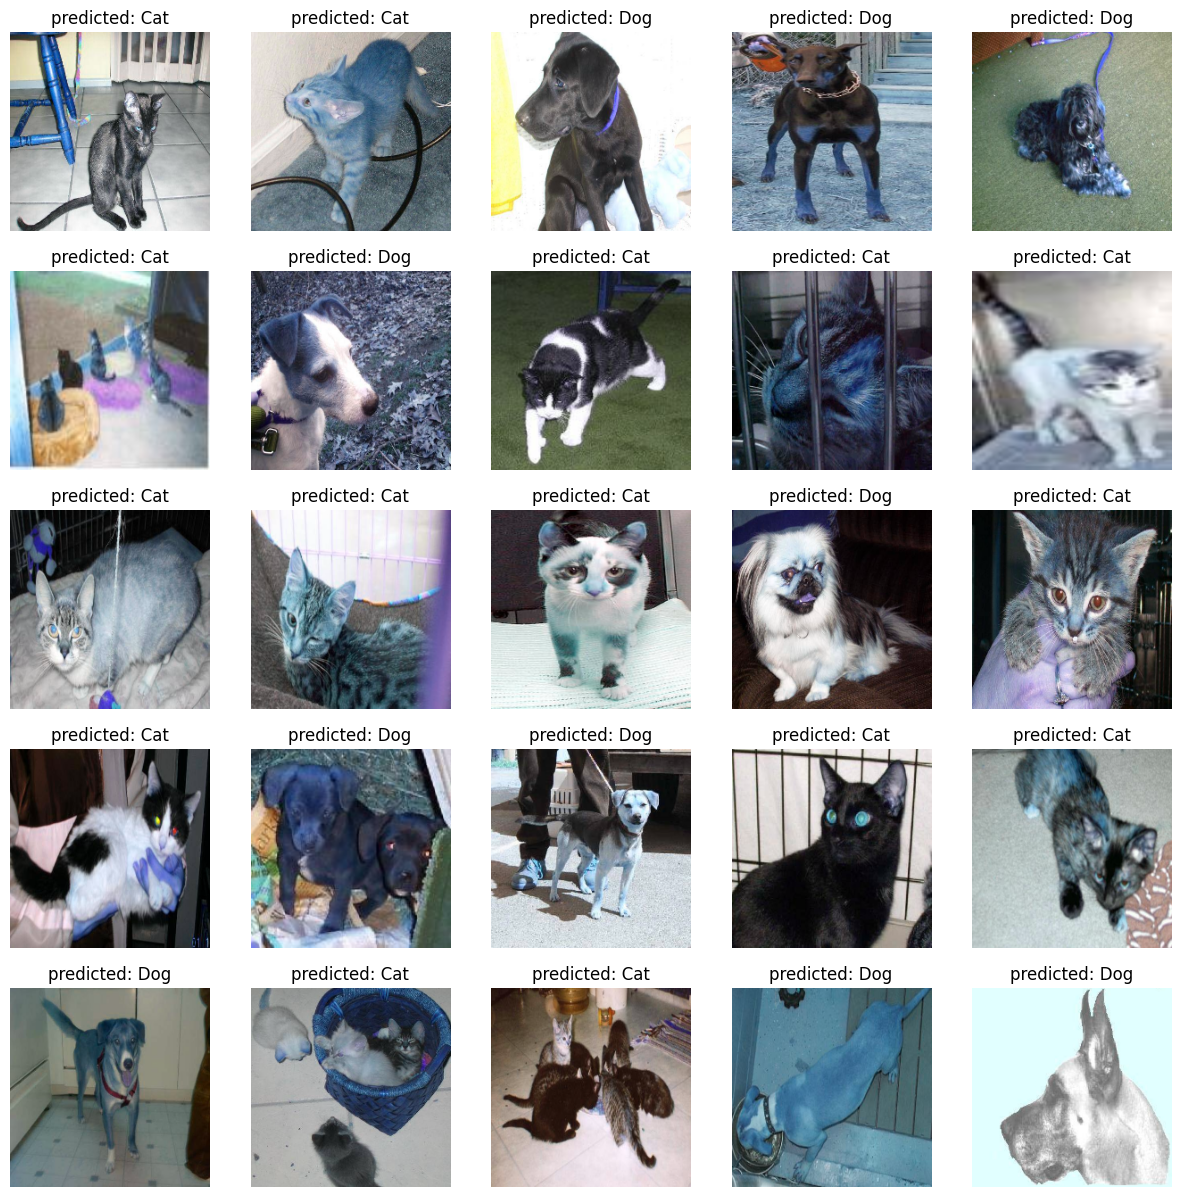

In [36]:
# 用测试集进行预测
f, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    img_data = torch.tensor(img_data, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0  # 转换为张量并归一化
    img_data = img_data.to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_data)
        _, predicted = torch.max(output, 1)
        label = 'Dog' if predicted.item() == 1 else 'Cat'
    
    ax[i //5, i%5].imshow(img_data.cpu().squeeze().permute(1, 2, 0).numpy())
    ax[i // 5, i%5].axis('off')
    ax[i//5,i%5].set_title(f"predicted: {label}")
plt.show()

In [ ]:
# 改进的测试集预测
def predict_test_set(model, test_loader, device):
    model.eval()
    predictions = []
    image_ids = []
    
    with torch.no_grad():
        for inputs, img_names in tqdm(test_loader, desc="预测测试集"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            predictions.extend(predicted.cpu().numpy())
            image_ids.extend(img_names)
    
    return predictions, image_ids

# 进行预测
pred_list, img_list = predict_test_set(model, test_loader, device)

print(f"预测完成，共处理 {len(pred_list)} 张图片")

100%|██████████| 12500/12500 [04:54<00:00, 42.47it/s]


In [38]:
# 保存模型
model_save_path = 'my_model.pth'
torch.save(model.state_dict(), model_save_path)

In [39]:
import pandas as pd
submission = pd.DataFrame({'id':img_list, 'label': pred_list})
submission.head()

id  label
0  11680      0
1  10183      0
2  11385      1
3   3789      1
4   9030      1

In [40]:
submission.to_csv('submission.csv', index=False)